# F-Praktikum 508

In diesem Notebook wird die Evaluation des Versuchs 508 durchgeführt. Mit dem Data vom EasyScan im Simulation Modus werden die Austrittsarbeit, LDOs und Ebenenabstand von Graphit bestimmt. 

Dieses Notebook wurde von Gerardo Gutierrez und Daniel Ehrhart gemacht. 

## Spectroskopie I(z)

Bei konstanter Bias Spannung wurde den Strom gemessen, während die z-Position der Spitze variiert wurde. Das rekopilierte Data wurde in einem `-csv` Datei gespeichert. In diesem Snippet soll nur das Datapath des Datei geändert werden, aber es kann möglicherweise auch nötig sein, Parameter wie `plt.xlim()` oder `plt.ylim()` zu ändern.

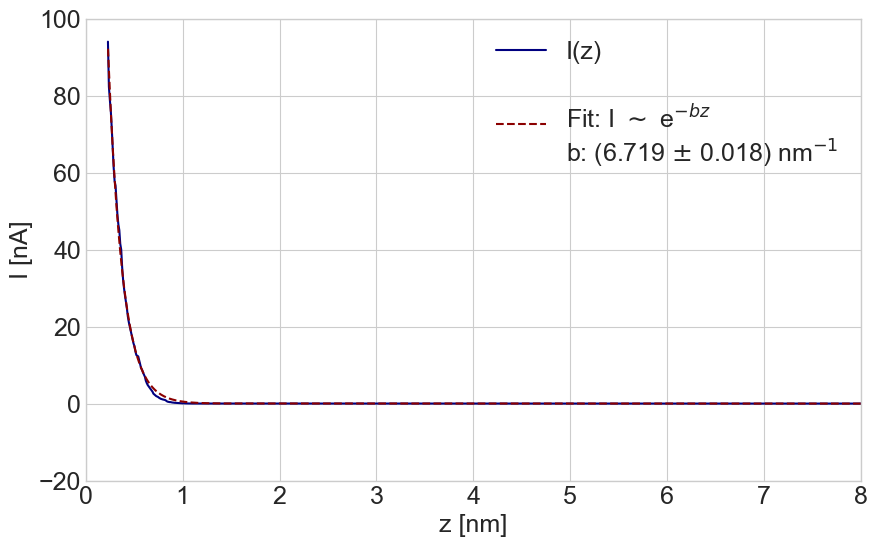

In [2]:
# Nötige Libraries importieren
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Data Importieren
data = pd.read_csv('data/spectrum.csv', delimiter=';', header=None)

# Data transponieren und skalieren (auf Nanometer)
data = (data.T)*1e9

# x und y Listen erstellen
x = data[0] # Position [nm]
x = [-a for a in x] 
x = [a+3 for a in x] # Verschiebung der Position, sodass x von 0 bis 8 läuft
x = np.array(x)
y = data[1] # Strom [nA]


# Data nach dem ersten Maximum schneiden
x, y = x[:np.argmax(y)], y[:np.argmax(y)]

# Fit Funktion definieren
def exponential(x, a, b):
    """
    Gibt das Ergebnis der Funktion f(x)=a*e^(bx) zurück
    """
    return a*np.exp(-b*x)

# Exponentielles Fit des Datensatzes
popt, pcov = curve_fit(exponential, x, y, p0=(1, 1))

# a, b Werte fitten
a_fit, b_fit = popt

# Gefittete Parameter mit der exponentiellen Funktion evaluieren
y_fit = exponential(x, a_fit, b_fit)

# Data plotten
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='I(z)', c='navy')
plt.plot(x, y_fit, label=f"\n" + r"Fit: I $\sim$ e$^{-bz}$ " + f"\nb: ({b_fit:.3f} " + r"$\pm$" + f" {np.sqrt(pcov[1][1]):.3f})" + r" nm$^{-1}$", ls="--", c="darkred")

# Grenzen der Achsen stellen
plt.xlim([0, 8])
plt.ylim([-20, 100])

# Achsen benennen
plt.ylabel('I [nA]', fontsize=18)
plt.xlabel('z [nm]', fontsize=18)

# Custom ticks
plt.xticks(ticks=np.arange(0, 9, 1), fontsize=18)  # x ticks im Intervall von 0 bis 8
plt.yticks(ticks=np.arange(-20, 101, 20), fontsize=18)  # y ticks im Intervall von -20 bis 100

# Legende ergänzen und Plot darstellen
plt.legend(fontsize=18)
plt.savefig("Iz_curve.png")
plt.show()

Mit dem Fit Parameter b, kann man die Austrittsarbeit mit der folgenden Formel bestimmen



<div style="text-align: center;">
    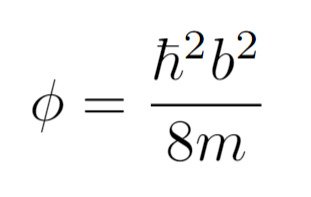
</div>

In [3]:
# Konstanten definieren
e = 1.602e-19 # [C]
pi = np.pi
h = 6.626e-34 # [Js]
h_bar = h/(2*pi) # [Js]

# Masse und effektive Masse des Elektrons
m = 9.11e-31 # [kg]
m_eff = 0.1*m # [kg]

# Kappa = b/2
kappa = (b_fit/2)*1e9 # [m^-1]
std_kappa = (np.sqrt(pcov[1][1]*100)/2)*1e9 

# Austrittsarbeit und Standardabweichung
phi = ((h_bar*kappa)**2)/(2*m_eff) # [J]
std_phi = ((h_bar**2)*kappa*std_kappa)/m_eff

# In eV umwandeln
phi_eV = phi/e # [eV]
std_phi_eV = std_phi/e

print(f"Work function of Graphit : ({phi_eV:.2f} +- {std_phi_eV:.2f}) eV")

Work function of Graphit : (4.30 +- 0.23) eV


## Spectroscopy I(U)

Bei konstantem Abstand und variierender Spannung, kann man durch den Strom die Verteilung der Elektronenzustände bestimmen. Die Elektronenzustände werden durch die Ableitung des Stroms bestimmt, was mit dem Algorithmus `gradient()` von `numpy` gemacht wird. Davor muss aber das Data geglättet werden, falls die Messung verräuscht ist. Dies erfolgt mit dem Algorithmus `gaussian_filter1d` von `scipy`. Für dieses Algorithmus je höher das Parameter `sigma`, desto weniger verräuscht wird das Data. `sigma=4` ist ein guter Wert für diese Messung, aber muss abhängig vom Data geändert werden.

<Figure size 1000x600 with 0 Axes>

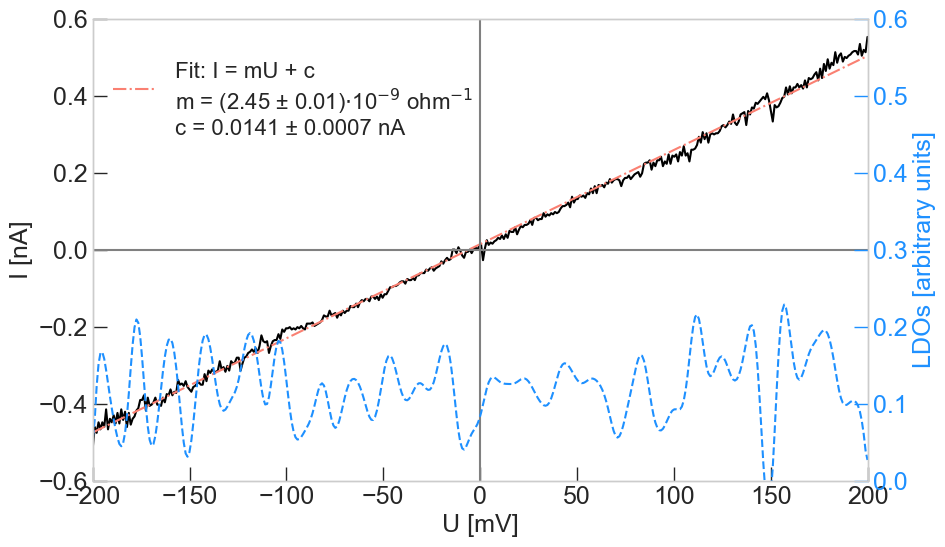

In [4]:
# Gaussian filter um das Data zu glätten
from scipy.ndimage import gaussian_filter1d

# Data importieren und transponieren
data = pd.read_csv('data/spectroscopy_IU.csv', delimiter=';', header=None)
data = data.T


x = data[0]*1e3 # Spannung [mV]
y = data[1]*1e9 # Strom [nA]

# Data nur im Bereich -200 to 200 evaluieren
y = y[(x > -200) & (x < 200)]
x = x[(x > -200) & (x < 200)]

# Strom glätten
y_smooth = gaussian_filter1d(y, sigma=4)

# Strom ableiten
y_prime = np.gradient(y_smooth, 0.02)

# Lineare Fit Funktion definieren
def linear(x, a, b):
    return a*x + b

# Lineares Fit des Datensatzes
popt, pcov = curve_fit(linear, x, y, p0=(1, 1))

# Fit Parameter a und b
a_fit, b_fit = popt

# Gefittete Parameter mit der exponentiellen Funktion evaluieren
y_fit = linear(x, a_fit, b_fit)

# Data Plotten
plt.figure(figsize=(10, 6))

# Erste achse mit dem Strom plotten
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(x, y, c='k')
ax1.plot(x, y_fit, label=f"\nFit: I = mU + c"
                         f"\nm = ({a_fit*1e3:.2f} ± {np.sqrt(pcov[0][0])*1e3:.2f})" +  r"$\cdot$10$^{-9}$ ohm$^{-1}$"
                         f"\nc = {b_fit:.4f} ± {np.sqrt(pcov[1][1]):.4f} nA", c="salmon", ls="-.")


# Erste Achse benennen
ax1.set_xlabel("U [mV]", fontsize=18)
ax1.set_ylabel("I [nA]", fontsize=18)

# Custom Ticks
ax1.tick_params(axis='y', labelsize=18, direction='in', length=10, width=1) 
ax1.tick_params(axis='x', labelsize=18, direction='in', length=10, width=1)

# Achsen begrenzen
ax1.set_xlim([-200, 200])
ax1.set_ylim([-0.6, 0.6])

# Zwei Geraden im Plot darstellen, eine bei x=0 und die zweite bei y=0
ax1.axhline(y=0, c="gray")
ax1.axvline(x=0, c="gray")
ax1.grid(False)

# Zweite Achse mit LDOs erstellen
ax2 = ax1.twinx()
ax2.plot(x, y_prime, c="dodgerblue", ls='--')

# Labels und Custom Ticks
ax2.set_ylabel("LDOs [arbitrary units]", fontsize=18, color="dodgerblue")
ax2.tick_params(axis='y', labelsize=18, colors="dodgerblue", direction='in', length=10, width=1)
ax2.set_ylim([0, 0.6])
ax2.grid(False)

# Legende beider Achsen kombinieren
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc='upper left')

# Speichern
plt.savefig("IU_Curve_with_Dual_Axis.png")
plt.show()

## Stufenkante Messung

In [457]:
d_1 = [1014, 1003, 1029, 990] # Gemessene Werte der ersten Stufenkante
dmean_1, dstd_1 = np.mean(d_1), np.std(d_1)
print(f"Mittelwert Stufenkante 1: d_1 = ({round(dmean_1)} +- {round(dstd_1)}) pm")

Mittelwert Stufenkante 1: d_1 = (1009 +- 14) pm


In [458]:
print(f"Mittelwert Stufenkante 1, divided by 3: d_1/3 = ({round(dmean_1/3)} +- {round(dstd_1/3)}) pm")

Mittelwert Stufenkante 1, divided by 3: d_1/3 = (336 +- 5) pm


In [459]:
d_2 = [320, 340, 335, 328] # Gemessene Werte der zweiten Stufenkante
dmean_2, dstd_2 = np.mean(d_2), np.std(d_2)
print(f"Mittelwert Stufenkante 2: d_2 = ({round(dmean_2)} +- {round(dstd_2)}) pm")

Mittelwert Stufenkante 2: d_2 = (331 +- 8) pm


In [461]:
d = (dmean_1/3 + dmean_2)/2 # Mittelwert
dstd = np.sqrt((dstd_1/6)**2 + (dstd_2/2)**2)
print(f"Gitterkonstante Graphit : d = ({round(d)} +- {round(dstd)}) pm")

Gitterkonstante Graphit : d = (334 +- 4) pm


In [462]:
d_lit = 335 # Litreturwert
print(f"Messabweichung : {abs(1 - d/d_lit)*100:.2f} %")

Messabweichung : 0.44 %


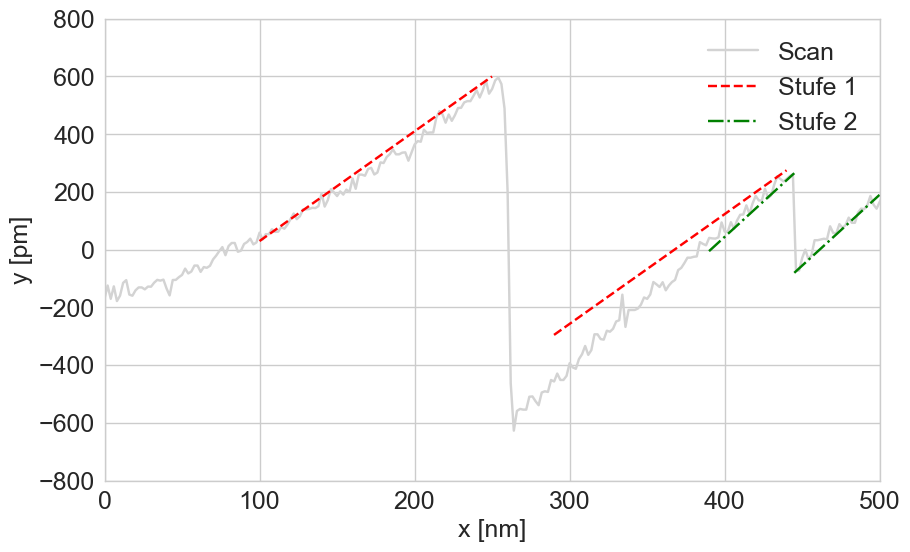

In [423]:
stufe1 = pd.read_csv('data/stufenkante1.csv', delimiter=';', header=None)
stufe1 = (stufe1.T)*1e9
x1, x2 = stufe1[0], stufe1[1]*1e3

# Plot the Sutfenkante
plt.figure(figsize=(10, 6))
plt.plot(x1, x2, c='lightgray', label="Scan")
plt.plot([290, 440], [-295, 275], c="red", label="Stufe 1", ls="--")
plt.plot([100, 250], [30, 600], c="red", ls="--")
plt.plot([390, 445], [-5, 265], c="green", ls="-.")
plt.plot([445, 500], [-80, 190], c="green", ls="-.", label="Stufe 2")
plt.ylim([-800, 800])
plt.xlim([0, 500])
plt.ylabel('y [pm]', fontsize=18)
plt.xlabel('x [nm]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig("stufenkante.png")
plt.show()

## Kalibrierung

### Length calculation

In [310]:
# Lenghts in x and y directions for calibration and calculation of the adjust factor
dx = [537.9, 900.7, 1297, 1240, 1249, 1281, 1048, 721.5, 356.3]
Nx = [3, 5, 7, 7, 7, 7, 6, 4, 2]
dy = [1208, 1395, 1233, 1354, 1206, 1412, 1197]
Ny = [7, 8, 7, 8, 7, 8, 7]

# Bond distances (dx/Nx)
bx = [a/b for a, b in zip(dx, Nx)]
by = [a/b for a, b in zip(dy, Ny)]

# Mean and std deviation
mean_bx, std_bx = np.mean(bx), np.std(bx)
mean_by, std_by = np.mean(by), np.std(by)

print(f"bx = ({round(mean_bx)} +- {round(std_bx)}) pm")
print(f"by = ({round(mean_by)} +- {round(std_by)}) pm")

bx = (180 +- 3) pm
by = (173 +- 2) pm


### Angle calculation

In [319]:
# Angle measurements
alpha = [22.82, 21.87, 25.16, 25.02, 23.54, 21.8, 24.9]
beta = [103.8, 101.5, 106.4, 105.9, 104.4, 103, 104.4]
beta = [a - b for a, b in zip(beta, alpha)]

# Mean and std deviation
mean_alpha, std_alpha = np.mean(alpha), np.std(alpha)
mean_beta, std_beta = np.mean(beta), np.std(beta)

print(f"alpha = ({mean_alpha:.1f} +- {std_alpha:.1f})°")
print(f"beta = ({mean_beta:.1f} +- {std_beta:.1f})°")

alpha = (23.6 +- 1.4)°
beta = (80.6 +- 0.7)°


### Coordinate system transformation

In [328]:
# Literature value of the graphit lattice constant
d = 246 # [pm]

# Calculation of the theoretical atom distance
x_e, y_e = mean_bx*np.cos(mean_alpha * np.pi / 180), mean_bx*np.sin(mean_alpha * np.pi / 180)
std_x_e = np.sqrt((std_bx*np.cos(mean_alpha * np.pi / 180))**2 + (mean_bx*(std_alpha * np.pi / 180)* np.sin(mean_alpha * np.pi / 180))**2)
std_y_e = np.sqrt((std_bx*np.sin(mean_alpha * np.pi / 180))**2 + (mean_bx*(std_alpha * np.pi / 180)* np.cos(mean_alpha * np.pi / 180))**2)

x_f, y_f = mean_by*np.cos(mean_beta * np.pi / 180), mean_by*np.sin(mean_beta * np.pi / 180)
std_x_f = np.sqrt((std_by*np.cos(mean_beta * np.pi / 180))**2 + (mean_by*(std_beta * np.pi / 180)* np.sin(mean_beta * np.pi / 180))**2)
std_y_f = np.sqrt((std_by*np.sin(mean_beta * np.pi / 180))**2 + (mean_by*(std_beta * np.pi / 180)* np.cos(mean_beta * np.pi / 180))**2)

std_x_e, std_y_e, std_x_f, std_y_f
print(f"Projection on the x-direction : x_e = ({round(x_e)} +- {round(std_x_e)}) pm | y_e = ({round(y_e)} +- {round(std_y_e)}) pm")
print(f"Projection on the y-direction : x_f = ({round(x_f)} +- {round(std_x_f)}) pm | y_f = ({round(y_f)} +- {round(std_y_f)}) pm")

Projection on the x-direction : x_e = (165 +- 3) pm | y_e = (72 +- 4) pm
Projection on the y-direction : x_f = (28 +- 2) pm | y_f = (171 +- 2) pm


In [331]:
vor_factor = (d**2)/((x_e*y_f)**2 - (x_f*y_e)**2)
std_vor_factor = 2*(d**2 / ((x_e*y_f)**2 - (x_f*y_e)**2)**2) * np.sqrt((x_e*std_x_e*y_f**2)**2 + (y_f*std_y_f*x_e**2)**2 + (x_f*std_x_f*y_e**2)**2 + (y_e*std_y_e*x_f**2)**2)

factor_X = vor_factor*(y_f**2 - y_e**2)
var_factor_X = (std_vor_factor*(y_f**2 - y_e**2))**2 + (2*y_f*std_y_f*vor_factor)**2 + (2*y_e*std_y_e*vor_factor)**2
std_factor_X = np.sqrt(var_factor_X)
factor_Y = vor_factor*(x_e**2 - x_f**2)
var_factor_Y = (std_vor_factor*(x_f**2 - x_e**2))**2 + (2*x_f*std_x_f*vor_factor)**2 + (2*x_e*std_x_e*vor_factor)**2
std_factor_Y = np.sqrt(var_factor_Y)

print(f"Factor X: {factor_X:.2f} +- {std_factor_X:.2f}")
print(f"Factor Y: {factor_Y:.2f} +- {std_factor_Y:.2f}")

Factor X: 1.85 +- 0.12
Factor Y: 2.02 +- 0.13
